# Statistical analyses for the Percolation Theory Simulator

The purpose of this notebook is to analyze the phenomena of Percolation.

1. We want to see if the percolation threshold depends on the size.
2. We want to analyze the distribution when the sample size gets increasingly bigger.
3. How the time needed before the system percolates varies on the size (fixing a threshold) or viceversa.

For this purpose we want to import the `api_utils` library, which implements the `APIConnector` class.

In [2]:
from api_utils import APIConnector

Now we want to define the server address, port and API path.

In [3]:
SERVER_ADDRESS = "0.0.0.0"
SERVER_PORT = "5000"
SERVER_PATH = "simulation/simulate"

ac = APIConnector(SERVER_ADDRESS, SERVER_PORT, SERVER_PATH)

print(ac.base_path)

http://0.0.0.0:5000/simulation/simulate/


## 1. How does size affect the Percolation Threshold?

The purpose of this section is to analyze if size affects the percolation threshold (which is defined as the probability of a cell site to be open).

### Data generation

First thing we need to do is to generate some simulation data. Simulation is done by using a minimum size of $n = 1$ and a maximum size of $n = 20$ (thus avoiding complex simulations due to the lattice increasing). Sample size will be $sample\_size = 100$, to reduce the standard error due to the sampling procedure.

In [4]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt

min_size = 1
max_size = 20
sample_size = 100

# Run only once. It might take up to 10 minutes
sample_thresholds = [ac.get_data(n, sample_size).get("threshold") for n in range(min_size, max_size + 1)]

### Data Visualization

Let's now visualize the results.

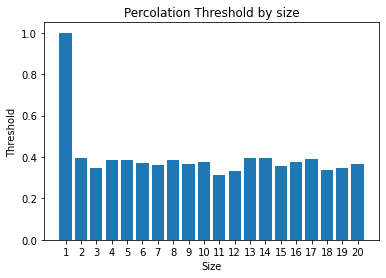

In [5]:
plt.title("Percolation Threshold by size")
plt.xlabel("Size")
plt.ylabel("Threshold")
plt.bar(range(min_size, max_size + 1), sample_thresholds)
plt.xticks(range(min_size, max_size + 1))

plt.show()

### Hypothesis Testing using _Chi-Squared Test_

From a first sight, we see that, except for size one, all the threshold are roughly equal. If we want to be rigorous about our statements, we might use the statistical framework, in particular we can use the _Chi-Squared Test_ and see if these differences are truly relevant (_Alternative Hypothesis_) or they are just due to random chance (_Null Hypothesis_).

It's trivial to understand why for size one the threshold is 1: in order for the system to percolate, the only site has to be open.

Having clarified this, and realizing that the percolation threshold is just the proportion of open sites, we can apply the _Chi-Squared Test_ using the relevant `scipy.stats` modules.

In [6]:
from scipy.stats import chisquare

chi2, pval = chisquare(sample_thresholds)

print(f"Calculated chi2 statistic is {chi2} and p-value {pval}")

Calculated chi2 statistic is 0.9768659203176914 and p-value 0.9999999993722517


### Conclusion

With such a huge p-value (0.99) it's impossible to reject the null hypothesis, therefore we can easily affirm that __the percolation threshold is not affected by the size__.

## 2. Distribution Analysis as the sample size varies.

Let's now see what varying the sample size causes to the distribution. Even though this is a purely statistical matter, we also want to see the shape of the distribution and we want to compare it with the Normal Distribution.

### Data
Since we realized that the threshold does not vary with size (for $n \gt 1$), we can choose $n = 10$ and our sample size will vary in the range $[20,\ 200]$ with a step of $20$. For each of these samples, we see perform a normality test to see whether the distribution is normal or not.

In [7]:
from scipy.stats import normaltest

n_sample_size = 10
min_sample_size = 20
max_sample_size = 200
step = 20

resulting_pvals = []

for sample_size in range(min_sample_size, max_sample_size + 1, step):
    sample = ac.get_data(n_sample_size, sample_size).get("results")
    resulting_pvals += [normaltest(sample)[1]]

resulting_pvals = np.array(resulting_pvals)
    

### Analysis

Let's check for which sample size the normality condition holds true. To do so, we choose a significance level of $\alpha = 0.05$, and when the resulting p-value is greater than such level, we can affirm that the sample comes from the normal distribution. Otherwise, we have to reject such hypothesis.

In [21]:
alpha = 0.05

np.where(resulting_pvals > alpha)[0].tolist()

[0, 1, 2]

The results look interesting, but it would be nice to repeat the process different times (let's say 20), and see if the results hold again. What we are going to do is: for each size we keep track how many times the sample is normal, and see if there's consistency among the results.

In [20]:
repeat = 20
results = [0 for _ in range(min_sample_size, max_sample_size + 1, step)]

for _ in range(repeat):
    resulting_pvals = []
    for sample_size in range(min_sample_size, max_sample_size + 1, step):
        sample = ac.get_data(n_sample_size, sample_size).get("results")
        resulting_pvals += [normaltest(sample)[1]]

    resulting_pvals = np.array(resulting_pvals)
    
    for index in np.where(resulting_pvals > alpha)[0].tolist():
        results[index] += 1

frequencies = [result / repeat for result in results]

for i, frequency in enumerate(frequencies):
    print(f"For size {min_sample_size + i * step}, the sample resulted normal {frequency * 100}% times.")

For size 20, the sample resulted normal 75.0% times.
For size 40, the sample resulted normal 95.0% times.
For size 60, the sample resulted normal 75.0% times.
For size 80, the sample resulted normal 40.0% times.
For size 100, the sample resulted normal 20.0% times.
For size 120, the sample resulted normal 5.0% times.
For size 140, the sample resulted normal 0.0% times.
For size 160, the sample resulted normal 0.0% times.
For size 180, the sample resulted normal 0.0% times.
For size 200, the sample resulted normal 0.0% times.


Usually we would expect the sample to be normal when it has a huge number of observations (from the "Law of great numbers"). Maybe a smaller sample is normal but as the number of observations increase the distribution gets skewed. You can visualize the data better in the R Shiny Dashboard.